# Bag of Visual Words Image Classification

## Implementation

### Pipeline

The process is divided into 3 independent steps using a scikit `Pipeline`. Its input is a list of pictures, with the keypoints and the descriptors. The steps are:

- SpatialPyramid: performs the clustering of the descriptors and calculates the histograms.
- StandardScaler: standarizes each column of the feature matrix.
- SVC: performs the classification.

Internally, the pipeline uses a cache in order to speed up repeated operations.

### GridSearchCV

We use scikit-learn class `GridSearchCV` in order to compute the parameter combinations. Internally, it performs cross-validation with the different combinations and returns the best result or, in our case, a table with all the results. This table is then wrapped around a pandas `DataFrame` and returned.

We are using 3 folds for the cross-validation and creating as many jobs as cores in the computer.

### Spatial pyramids

The Bag of Visual Words model is a great solution to aggregate local features into a single global descriptor vector. But this approach has a flaw: it completely ignores all information about the spatial layout of the features, so it has severely limited descriptive ability. To overcome this limitation, spatial pyramids of descriptors are used.

Informally, spatial pyramids work by partitioning the image into increasingly fine sub-regions and computing histograms of the codewords inside each sub-region; the grid at level $l$ has $2^l$ cells along each dimension, for a total of $D = 2^{dl}$ cells. Furthermore, descriptor vectors at finer resolutions are weighted more; the weight associated with level $l$ is set to $\frac{1}{2^{n\_levels-l}}$, which is inversely proportional to cell width at that level. Intuitively, we want to penalize matches found in larger cells because they involve increasingly dissimilar features. 

### Histogram intersection kernel

Since our descriptor vectors are histograms, it makes sense that we compute the similarity of such vectors with their histogram intersection. We use the following implementation for the histogram intersection kernel:

```python
def histogram_intersection_kernel(x, u):
    n_samples, n_features = x.shape
    K = np.zeros((x.shape[0], u.shape[0]), dtype=np.float32)
    for d in range(n_samples):
        K[d, :] = np.sum(np.minimum(x[d], u), axis=1)
    return K
```

### Default parameters

To run each experiment we use the following default parameters, unless otherwise specified:

```python
DenseSIFT:
  step_size=16
  scales=(4, 8, 12, 16)
  
SpatialPyramid:
    n_clusters=500
    n_samples=10000
    norm='l2'
    n_levels=2
  
SVC:
    C=1
    kernel='rbf'
    gamma=.001
```   

In [1]:
from argparse import Namespace

import numpy as np
from matplotlib import pyplot as plt

from descriptors.histogram_intersection_kernel import histogram_intersection_kernel
from main import main


def run_experiment(param_grid: dict):
    args = Namespace(train_path='../data/MIT_split/train',
                     test_path='../data/MIT_split/test',
                     cache_path='../.cache')
    return main(args, param_grid)


## Experiments
### Codebook sampling
Since we run Dense SIFT with a small `step_size` and for several `scales` at each location, we get a great amount of descriptor vectors. But we don't need all of them for the construction of the codebook, we can get away with a random subset of those. In this experiment, we test different amounts of samples used for the creation of the codeebok.

Extract train descriptors: 0.885916s
Extract test descriptors: 0.368029s
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Train: 568.770287s
Test: 17.291676s
Best params: {'transformer__n_samples': 100000}
Accuracy: 0.7149938042131351


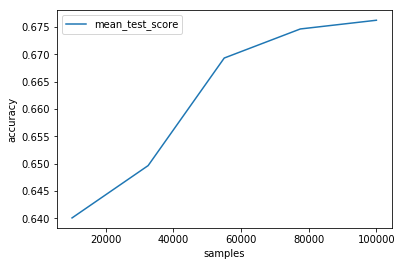

In [2]:
param_grid = {
    'transformer__n_samples': np.linspace(10000, 100000, 5, dtype=int),
}
results = run_experiment(param_grid)

results.plot.line(x='param_transformer__n_samples', y='mean_test_score')
plt.xlabel('samples')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()

Above we see the comparison between the accuracy and the number of samples, keypoints, used. We can observe that taking a larger number of samples increases the accuracy only slightly. Nevertheless, the execution time of the algorithm increases linearly. Therefore, taking into account the tradeoff between accuracy and computational complexity, we used 10000 samples in our experiments.

### Codebook size
In this experiment, we test different codebook sizes or, in other words, different number of clusters for the K-Means algorithm used to generate the codebook. We try sizes multiples of 2.

Extract train descriptors: 0.827541s
Extract test descriptors: 0.338618s
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Train: 545.927934s
Test: 9.846766s
Best params: {'transformer__n_clusters': 760, 'transformer__n_levels': 1}
Accuracy: 0.8488228004956629


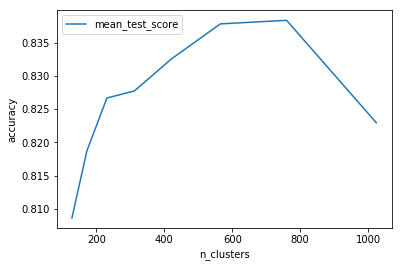

In [3]:
param_grid = {
    'transformer__n_clusters': np.logspace(7, 10, 8, base=2, dtype=int),
    'transformer__n_levels': [1]
}
results = run_experiment(param_grid)

results.plot.line(x='param_transformer__n_clusters', y='mean_test_score')
plt.xlabel('n_clusters')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()

Using a larger number of kernels slightly increses the classification accuracy while the procesing time also increases. It's important to take notice that using more than 800 clusters worses the classification. As the number of clusters grows, it makes the words in the codebook more specific, since there are more codewords that could represent any vector of descriptors. But there's an inflection point from which making the vocabulary more specific doesn't help in distinguishing between classes; in our case, this point is around 800 clusters. With more than 800 codewords, the histogram that represents an image (or region) has too many bins containing low values, which provides a poor representation of the image (or region) because differences are smoothed.

### Normalization of descriptors
In this experiment, we test different types of normalization of the descriptor vectors. We try L1-norm, L2-norm and Power-norm, which consists in applying to each dimension the following function:

$f(z) = \operatorname{sign}(z)|z|^{\alpha}$

where $0 \leq \alpha \leq 1$ is a parameter of the normalization. We fix $\alpha = 0.5$ throughout all our experiments. (https://www.robots.ox.ac.uk/~vgg/rg/papers/peronnin_etal_ECCV10.pdf)

Extract train descriptors: 0.577312s
Extract test descriptors: 0.254418s
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Train: 351.914704s
Test: 17.817160s
Best params: {'transformer__norm': 'power'}
Accuracy: 0.7620817843866171


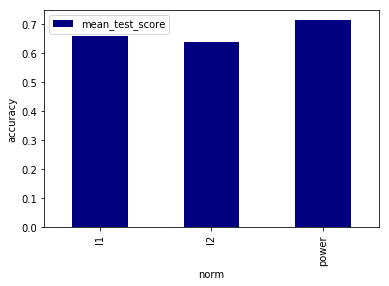

In [4]:
param_grid = {
    'transformer__norm': ['l1', 'l2', 'power'],
}
results = run_experiment(param_grid)

# Colormap needed until a bug is fixed in next version of pandas.
results.plot.bar(x='param_transformer__norm', y='mean_test_score', colormap='jet')
plt.xlabel('norm')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()

As we can observe, all norms perform quite similarly, although power norm is slightly better than the other 2.

### Spatial Pyramid levels
In this experiment, we test different number of levels for the spatial pyramid that takes into account the location of the descriptors to generate a global image descriptor.

Extract train descriptors: 0.607145s
Extract test descriptors: 0.267276s
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Train: 363.947076s
Test: 8.484948s
Best params: {'transformer__n_levels': 1}
Accuracy: 0.8451053283767038


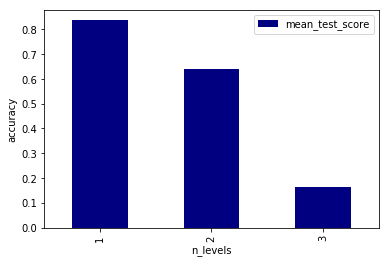

In [5]:
param_grid = {
    'transformer__n_levels': np.linspace(1, 3, 3, dtype=int),
}
results = run_experiment(param_grid)

# Colormap needed until a bug is fixed in next version of pandas.
results.plot.bar(x='param_transformer__n_levels', y='mean_test_score', colormap='jet')
plt.xlabel('n_levels')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.show()

Using the same parameteres and adding more levels to the spatial pyramid, only changing the levels without fine-tunig, doesn't seem to improve the results. Nevertheless, as it can be seen in the kernel type comparison section below, we obtained the best results with `n_levels=2`.

### Kernel type and penalty parameter
In this experiment, we test different kernels and values for the penalty parameter `C` of the error term of the classifier. We also investigate how different number of spatial pyramid levels may affect.

Extract train descriptors: 0.899068s
Extract test descriptors: 0.455976s
Fitting 3 folds for each of 40 candidates, totalling 120 fits
Train: 3708.124748s
Test: 34.851612s
Best params: {'classifier__C': 0.125, 'classifier__kernel': <function histogram_intersection_kernel at 0x7f7b968d9d90>, 'transformer__n_levels': 2}
Accuracy: 0.8773234200743495


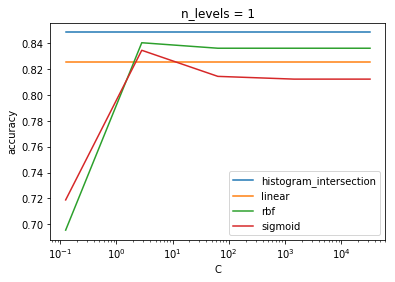

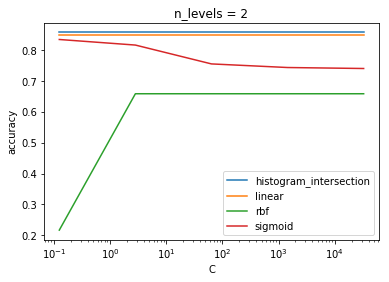

In [7]:
param_grid = {
    'classifier__kernel': ['linear', 'rbf', 'sigmoid', histogram_intersection_kernel],
    'classifier__C': np.logspace(-3, 15, 5, base=2),
    'transformer__n_levels': [1, 2]
}

results = run_experiment(param_grid)
results.loc[results.param_classifier__kernel == histogram_intersection_kernel, 'param_classifier__kernel'] = \
    "histogram_intersection"

results[results.param_transformer__n_levels == 1] \
    .pivot(index='param_classifier__C', columns='param_classifier__kernel', values='mean_test_score') \
    .plot.line(logx=True)
plt.xlabel('C')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.title('n_levels = 1')
plt.show()

results[results.param_transformer__n_levels == 2] \
    .pivot(index='param_classifier__C', columns='param_classifier__kernel', values='mean_test_score') \
    .plot.line(logx=True)
plt.xlabel('C')
plt.ylabel('accuracy')
plt.legend(loc='best')
plt.title('n_levels = 2')
plt.show()

From the graphs above, we can crearly observe that both linear and histogram intersection kernels are not affected by the penalty parameter `C`. It is also important to realize that changing the number of levels greatly impacts the results, specifically for RBF kernel, which is the second best with `n_levels=1` but the worst with `n_levels=2`.

Histogram intersection kernel is crearly the best of all of them.

### Kernel type and kernel coefficient
In this experiment, we test different kernels and values for the kernel coefficient `gamma` of the classifier.

Extract train descriptors: 0.916644s
Extract test descriptors: 0.343593s
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Train: 2240.159596s
Test: 33.397511s
Best params: {'classifier__gamma': 3.0517578125e-05, 'classifier__kernel': <function histogram_intersection_kernel at 0x7f7b968d9d90>}
Accuracy: 0.8773234200743495


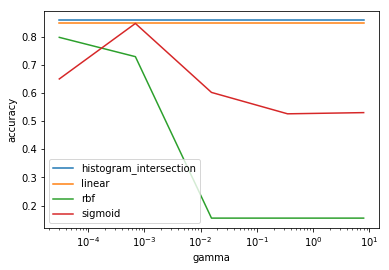

In [8]:
param_grid = {
    'classifier__kernel': ['linear', 'rbf', 'sigmoid', histogram_intersection_kernel],
    'classifier__gamma': np.logspace(-15, 3, 5, base=2)
}

results = run_experiment(param_grid)
results.loc[results.param_classifier__kernel == histogram_intersection_kernel, 'param_classifier__kernel'] = \
    "histogram_intersection"

results.pivot(index='param_classifier__gamma', columns='param_classifier__kernel', values='mean_test_score') \
    .plot.line(logx=True)

plt.xlabel('gamma')
plt.ylabel('accuracy')
plt.legend(loc='best')

plt.show()

As it happens with the penalty parameter `C`, histogram intersection and linear kernels are not affected by the `gamma` coefficient. Furthermore, as we can see, those kernels are also the ones that provide the best accuracy. Results above were extracted using `n_levels=2`, that is why the RBF kernel performs bad.